In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import torch
import torch.nn as nn
from tab_transformer_pytorch import TabTransformer 
from preprocessing import get_features_and_target

In [ ]:
cont_mean_std = torch.randn(16, 2)

model = TabTransformer(
    categories = (9,16 ),      # tuple containing the number of unique values within each category
    num_continuous = 16,                # number of continuous values
    dim = 32,                           # dimension, paper set at 32
    dim_out = 1,                        # binary prediction, but could be anything
    depth = 6,                          # depth, paper recommended 6
    heads = 8,                          # heads, paper recommends 8
    attn_dropout = 0.1,                 # post-attention dropout
    ff_dropout = 0.1,                   # feed forward dropout
    mlp_hidden_mults = (4, 2),          # relative multiples of each hidden dimension of the last mlp to logits
    mlp_act = nn.ReLU(),                # activation for final mlp, defaults to relu, but could be anything else (selu etc)
    continuous_mean_std = cont_mean_std # (optional) - normalize the continuous values before layer norm
)

x_categ = (9, 12)     # category values, from 0 - max number of categories, in the order as passed into the constructor above
x_cont = (1, 16)               # assume continuous values are already normalized individually

pred = model(x_categ, x_cont) # (1, 1)
print(pred)
print(pred)


AttributeError: 'tuple' object has no attribute 'shape'

In [3]:
import torch
from tab_transformer_pytorch import FTTransformer

model = FTTransformer(
    categories = (1,1),      # tuple containing the number of unique values within each category
    num_continuous = 10,                # number of continuous values
    dim = 32,                           # dimension, paper set at 32
    dim_out = 1,                        # binary prediction, but could be anything
    depth = 6,                          # depth, paper recommended 6
    heads = 8,                          # heads, paper recommends 8
    attn_dropout = 0.1,                 # post-attention dropout
    ff_dropout = 0.1                    # feed forward dropout
)

x_categ = torch.randint(0, 1, (1, 2))     # category values, from 0 - max number of categories, in the order as passed into the constructor above
x_numer = torch.randn(1, 10)              # numerical value

pred = model(x_categ, x_numer) # (1, 1)

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import TabTransformer
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Generate fake data
def generate_data(num_samples):
    x_categ = torch.randint(0, 10, (num_samples, 5))
    
    x_cont = torch.randn(num_samples, 15)
    
    y = torch.zeros(num_samples)
    for i in range(num_samples):
        if x_categ[i, 0] > 5 and x_cont[i, 0] > 0:
            y[i] = 2  
        elif x_categ[i, 1] < 3 or x_cont[i, 1] < -1:
            y[i] = 1 
        else:
            y[i] = 0  
    
    return x_categ, x_cont, y.long()

num_samples = 10000
x_categ, x_cont, y = generate_data(num_samples)

cont_mean = x_cont.mean(dim=0)
cont_std = x_cont.std(dim=0)
x_cont = (x_cont - cont_mean) / cont_std 
cont_mean_std = torch.stack([cont_mean, cont_std], dim=1)

# Model
model = TabTransformer(
    categories = (10, 10, 10, 10, 10), 
    num_continuous = 15,                
    dim = 64,                            
    dim_out = 3,                        
    depth = 6,                           
    heads = 8,                          
    attn_dropout = 0.1,                  
    ff_dropout = 0.1,                    
    mlp_hidden_mults = (4, 2),           
    mlp_act = nn.ReLU(),                 
    continuous_mean_std = cont_mean_std  
)

dataset = TensorDataset(x_categ, x_cont, y)
train_size = int(0.8 * len(dataset))  
test_size = len(dataset) - train_size 
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  

criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

num_epochs = 2

# Train
for epoch in range(num_epochs):
    model.train()  
    total_loss = 0
    all_preds = []  
    all_labels = []  

    for batch_categ, batch_cont, batch_y in train_loader:
        
        optimizer.zero_grad()  
        
        outputs = model(batch_categ, batch_cont)
        loss = criterion(outputs, batch_y)  
        
        loss.backward() 
        optimizer.step()  
        
        total_loss += loss.item()  
        
        _, predicted = torch.max(outputs.data, 1) 
        all_preds.extend(predicted.numpy())  
        all_labels.extend(batch_y.numpy())  
    
    avg_loss = total_loss / len(train_loader)
    
    accuracy = accuracy_score(all_labels, all_preds)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch [1/2], Loss: 0.6152, Accuracy: 0.7224
Epoch [2/2], Loss: 0.4350, Accuracy: 0.8031


In [8]:
models = {
    "FTTransformer": FTTransformer(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
}

TypeError: FTTransformer.__init__() got an unexpected keyword argument 'random_state'

In [2]:
train_df = pd.read_csv("data/train_data.csv")
dev_df = pd.read_csv("data/development_data.csv")

x_train, y_train = get_features_and_target(train_df)
x_dev, y_dev = get_features_and_target(dev_df)

target_column = "PullTest (N)"  


In [3]:
X, y = get_features_and_target(train_df)
num_unique_materials = X["Material"].nunique()
num_cont_features = X.shape[1] - 1



In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X['Material'] = le.fit_transform(X['Material'])


In [5]:
sample = X.iloc[0]

# Get the encoded material category value
material_idx = sample["Material"]
x_categ = torch.tensor([[material_idx]], dtype=torch.long)

# Drop the "Material" column to get the continuous features
x_numer = torch.tensor([sample.drop("Material").to_numpy()], dtype=torch.float)

C:\Users\Marcus\AppData\Local\Temp\ipykernel_2964\1061618069.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  x_numer = torch.tensor([sample.drop("Material").to_numpy()], dtype=torch.float)


In [15]:
import torch
import torch.nn as nn
from tab_transformer_pytorch import TabTransformer



model = FTTransformer(
    categories = (num_unique_materials,),  # Only one categorical feature
    num_continuous = num_cont_features,    # Number of continuous columns after preprocessing
    dim = 64,
    dim_out = 1,
    depth = 6,
    heads = 8,
    attn_dropout = 0.9,
    ff_dropout = 0.9
)

x_categ = torch.tensor([[material_idx]], dtype=torch.long)
x_numer = torch.tensor([sample.drop("Material").to_numpy()], dtype=torch.float)



pred = model(x_categ, x_numer) # (1, 1)
print(pred)

tensor([[0.4484]], grad_fn=<AddmmBackward0>)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split
X, y = get_features_and_target(train_df)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode Material
le = LabelEncoder()
X_train["Material"] = le.fit_transform(X_train["Material"])
X_val["Material"] = le.transform(X_val["Material"])


In [7]:
from torch.utils.data import Dataset

class WeldingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row = self.X.iloc[idx]
        x_categ = torch.tensor([row["Material"]], dtype=torch.long)
        x_numer = torch.tensor(row.drop("Material").to_numpy(), dtype=torch.float)
        target = torch.tensor(self.y[idx], dtype=torch.float)
        return x_categ, x_numer, target


In [8]:
from torch.utils.data import DataLoader

train_ds = WeldingDataset(X_train, y_train)
val_ds = WeldingDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)


In [19]:
import torch.nn as nn
import torch.optim as optim

model = FTTransformer(
    categories=(len(le.classes_),),
    num_continuous=X_train.shape[1] - 1,
    dim=128,
    dim_out=1,
    depth=6,
    heads=8,
    attn_dropout=0.9,
    ff_dropout=0.9
)

import plotly.graph_objects as go

train_losses = []
val_losses = []

for epoch in range(10):
    model.train()
    epoch_train_loss = 0
    for x_categ, x_numer, target in train_loader:
        optimizer.zero_grad()
        preds = model(x_categ, x_numer).squeeze()
        loss = criterion(preds, target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🔍 Validation
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for x_categ, x_numer, target in val_loader:
            preds = model(x_categ, x_numer).squeeze()
            loss = criterion(preds, target)
            epoch_val_loss += loss.item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")




Epoch 1 | Train Loss: 321275.9509 | Val Loss: 266071.6172
Epoch 2 | Train Loss: 321435.9799 | Val Loss: 266071.6172
Epoch 3 | Train Loss: 322136.1741 | Val Loss: 266071.6172
Epoch 4 | Train Loss: 322029.5714 | Val Loss: 266071.6172
Epoch 5 | Train Loss: 321715.2768 | Val Loss: 266071.6172
Epoch 6 | Train Loss: 321826.6987 | Val Loss: 266071.6172
Epoch 7 | Train Loss: 321259.3170 | Val Loss: 266071.6172
Epoch 8 | Train Loss: 321735.8549 | Val Loss: 266071.6172
Epoch 9 | Train Loss: 321409.9375 | Val Loss: 266071.6172
Epoch 10 | Train Loss: 321833.7589 | Val Loss: 266071.6172


In [9]:
import pandas as pd
from preprocessing import get_features_and_target
from sklearn.preprocessing import LabelEncoder
import torch

# Load data
df = pd.read_csv("data/train_data.csv")

# Preprocess
X, y = get_features_and_target(df)

# Encode categorical column
le = LabelEncoder()
X["Material"] = le.fit_transform(X["Material"])

# Prepare tensors
x_categ = torch.tensor(X["Material"].values, dtype=torch.long).unsqueeze(1)  # shape (N, 1)
x_cont = torch.tensor(X.drop("Material", axis=1).values, dtype=torch.float)   # shape (N, num_cont_features)
y_tensor = torch.tensor(y.values, dtype=torch.float)

In [10]:
from tab_transformer_pytorch import FTTransformer

model = FTTransformer(
    categories=(len(le.classes_),),  # number of unique materials
    num_continuous=x_cont.shape[1],  # number of continuous features
    dim=64,
    dim_out=1,
    depth=6,
    heads=8,
    attn_dropout=0.1,
    ff_dropout=0.1
)



In [11]:
with torch.no_grad():
    pred = model(x_categ, x_cont)
print(pred.shape)

torch.Size([274, 1])


In [12]:
from sklearn.preprocessing import StandardScaler

# Scale target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()

In [13]:
from sklearn.preprocessing import StandardScaler

# Scale continuous features
cont_cols = X_train.columns.drop("Material")
scaler_X = StandardScaler()
X_train[cont_cols] = scaler_X.fit_transform(X_train[cont_cols])
X_val[cont_cols] = scaler_X.transform(X_val[cont_cols])
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

In [14]:
y_scaled = pd.Series(y_scaled, index=y.index)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import RMSELoss

# Define RMSELoss directly in the notebook to avoid import issues
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yhat, y):
        return torch.sqrt(torch.mean((yhat - y) ** 2))

# Custom Dataset for Tabular Data
class WeldingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row = self.X.iloc[idx]
        x_categ = torch.tensor([row["Material"]], dtype=torch.long)
        x_numer = torch.tensor(row.drop("Material").to_numpy(), dtype=torch.float)
        target = torch.tensor(self.y.iloc[idx], dtype=torch.float)
        return x_categ, x_numer, target

# Split into train/val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Datasets and DataLoaders
train_ds = WeldingDataset(X_train, y_train)
val_ds = WeldingDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Model, Loss, Optimizer
model = FTTransformer(
    categories=(len(le.classes_),),
    num_continuous=x_cont.shape[1],
    dim=16,
    dim_out=1,
    depth=4,
    heads=4,
    attn_dropout=0.3,
    ff_dropout=0.3
)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
#prev lr = 0.01

# Training and Validation Loop
num_epochs = 1000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for x_categ, x_numer, target in train_loader:
        optimizer.zero_grad()
        preds = model(x_categ, x_numer).squeeze()
        loss = criterion(preds, target)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for x_categ, x_numer, target in val_loader:
            preds = model(x_categ, x_numer).squeeze()
            loss = criterion(preds, target)
            epoch_val_loss += loss.item()
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch 1 | Train Loss: 2975.6613 | Val Loss: 2925.1812
Epoch 2 | Train Loss: 2975.0357 | Val Loss: 2925.1700
Epoch 3 | Train Loss: 2974.4569 | Val Loss: 2925.1589
Epoch 4 | Train Loss: 2974.6929 | Val Loss: 2925.1478
Epoch 5 | Train Loss: 2979.2631 | Val Loss: 2925.1366
Epoch 6 | Train Loss: 2978.3527 | Val Loss: 2925.1254
Epoch 7 | Train Loss: 2976.0774 | Val Loss: 2925.1140
Epoch 8 | Train Loss: 2975.7725 | Val Loss: 2925.1029
Epoch 9 | Train Loss: 2979.2122 | Val Loss: 2925.0916
Epoch 10 | Train Loss: 2978.7967 | Val Loss: 2925.0803
Epoch 11 | Train Loss: 2978.6965 | Val Loss: 2925.0691
Epoch 12 | Train Loss: 2974.4765 | Val Loss: 2925.0576
Epoch 13 | Train Loss: 2977.8728 | Val Loss: 2925.0455
Epoch 14 | Train Loss: 2975.5064 | Val Loss: 2925.0337
Epoch 15 | Train Loss: 2977.4594 | Val Loss: 2925.0215
Epoch 16 | Train Loss: 2977.2197 | Val Loss: 2925.0093
Epoch 17 | Train Loss: 2976.8612 | Val Loss: 2924.9972
Epoch 18 | Train Loss: 2976.6198 | Val Loss: 2924.9849
Epoch 19 | Train Lo

KeyboardInterrupt: 

In [34]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=train_losses,
    mode="lines+markers",
    name="Train Loss"
))

fig.add_trace(go.Scatter(
    y=val_losses,
    mode="lines+markers",
    name="Validation Loss"
))

fig.update_layout(
    title="Training & Validation Loss Over Epochs",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    xaxis = dict(tickmode='linear'),  # optional: shows every epoch
    template="plotly_white"
)

fig.show()


In [35]:
import plotly.graph_objects as go

fig = go.Figure()

# Training loss trace
fig.add_trace(go.Scatter(
    y=train_losses,
    x=list(range(1, len(train_losses)+1)),
    mode="lines+markers",
    name="Training Loss",
    line=dict(color="royalblue", width=2),
    marker=dict(size=6)
))

# Validation loss trace
fig.add_trace(go.Scatter(
    y=val_losses,
    x=list(range(1, len(val_losses)+1)),
    mode="lines+markers",
    name="Validation Loss",
    line=dict(color="tomato", width=2),
    marker=dict(size=6)
))

# Layout
fig.update_layout(
    title="Training & Validation Loss over Epochs",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    xaxis=dict(tickmode='linear'),
    template="plotly_white",
    legend=dict(x=0.02, y=0.98, bgcolor="rgba(255,255,255,0)", borderwidth=0)
)

fig.show()


In [58]:
import plotly.graph_objects as go

epochs = list(range(1, len(train_losses) + 1))

fig = go.Figure()

# Training loss trace
fig.add_trace(go.Scatter(
    x=epochs,
    y=train_losses,
    mode="lines",
    name="Training Loss",
    line=dict(color="royalblue", width=2)
))

# Validation loss trace
fig.add_trace(go.Scatter(
    x=epochs,
    y=val_losses,
    mode="lines",
    name="Validation Loss",
    line=dict(color="firebrick", width=2, dash="dash")
))

# Layout enhancements
fig.update_layout(
    title="Training & Validation Loss over 100 Epochs",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(0, 1001, 100)),  # Show ticks every 10 epochs
        tickfont=dict(size=10)
    ),
    yaxis=dict(
        tickformat=".2e" if max(train_losses + val_losses) > 1e4 else ".4f",  # Dynamic formatting
        gridcolor="lightgray"
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    template="plotly_white",
    margin=dict(t=60, b=40)
)

fig.show()


In [55]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Collect predictions and true values from the validation set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for x_categ, x_numer, target in val_loader:
        preds = model(x_categ, x_numer).squeeze().cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(target.cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Inverse-transform predictions and targets to original units
preds_orig = scaler_y.inverse_transform(all_preds.reshape(-1, 1)).flatten()
targets_orig = scaler_y.inverse_transform(all_targets.reshape(-1, 1)).flatten()

# Calculate MAE and RMSE in original units
mae = mean_absolute_error(targets_orig, preds_orig)
rmse = np.sqrt(mean_squared_error(targets_orig, preds_orig))

print(f"MAE (original units): {mae:.2f}")
print(f"RMSE (original units): {rmse:.2f}")

MAE (original units): 201.05
RMSE (original units): 342.08


In [ ]:

regressor.fit(X_train, y_train)

predictions = regressor.predict(X_dev)

mse = mean_squared_error(y_dev, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_dev, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

abs_errors = np.abs(predictions - y_dev)
sorted_errors = np.sort(abs_errors)
cdf = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)

plt.figure(figsize=(8, 5))
plt.plot(sorted_errors, cdf, marker='.', linestyle='none')
plt.xlabel('Absolute Error |y_pred - y_true|')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function (CDF) of Absolute Errors')
plt.grid(True)
plt.show()

NameError: name 'predictions' is not defined

## Coefficient of Determination (R²)

The coefficient of determination, denoted as $( R^2 )$, is a commonly used metric to evaluate the performance of a regression model. It indicates how well the model explains the variance in the target variable \( y \).

### Definition

The formula for $( R^2 )$ is:

$$
R^2 = 1 - \frac{SS_{\text{res}}}{SS_{\text{tot}}}
$$

Where:

- $( SS_{\text{res}} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2)$: Residual Sum of Squares (model error)
-  $(SS_{\text{tot}} = \sum_{i=1}^{n} (y_i - \bar{y})^2)$: Total Sum of Squares (total variance in the data)

### Interpretation

- $( R^2 = 1)$: Perfect prediction – the model explains 100% of the variance in $( y)$
- $( R^2 = 0)$: The model does no better than simply predicting the mean of $( y )$
- $( R^2 < 0 )$: The model performs worse than a constant mean prediction

### Example

In this case, the model achieved an $( R^2 )$ score of **0.61**, which means it explains **61% of the total variance** in the target variable.

This is a moderate-to-good result, indicating that the model captures significant patterns in the data, but there is still room for improvement.

## Mean Squared Error (MSE)

The **Mean Squared Error (MSE)** is a standard regression metric that measures the average of the squared differences between the predicted values and the actual target values.

### Definition

$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

Where:

- $y_i$: true value  
- $\hat{y}_i$: predicted value  
- $n$: number of samples

### Interpretation

- MSE penalizes larger errors more strongly due to squaring.
- The result is in the **squared unit** of the target variable (e.g., mm², N², €²).
- A **lower MSE** indicates better prediction accuracy.
- Because of squaring, the MSE is sensitive to **outliers**.

### Example

In this case, the model yielded an MSE of **88,837**, which may seem large, but this must be interpreted in the context of the unit and range of the target variable.

## Root Mean Squared Error (RMSE)

The **Root Mean Squared Error (RMSE)** is the square root of the MSE and represents the average prediction error in the same unit as the target variable.

### Definition

$RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 } = \sqrt{MSE}$

### Interpretation

- RMSE is easier to interpret than MSE because it is in the **original unit** of the target variable.
- It gives a direct sense of **how far off predictions are**, on average.
- Like MSE, it is also sensitive to outliers due to the squaring.

### Example

In this case, the RMSE is approximately **298 N**.  
Given that the mean of the target variable (PullTest) is **2953 N**, this corresponds to a **relative prediction error of about 10.1 %**.

This means that, on average, the model's predictions deviate from the true pull test values by approximately 298 N.


In [12]:
results = {}

X_train_new = X_train.drop(columns=["Material", "Category", "Comments"])
X_dev_new = X_dev.drop(columns=["Material", "Category", "Comments"])

for name, model in models.items():
    model.fit(X_train_new, y_train)
    preds = model.predict(X_dev_new)
    
    mse = mean_squared_error(y_dev, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_dev, preds)
    
    results[name] = {
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }

NameError: name 'models' is not defined

In [29]:
results_df = pd.DataFrame(results).T
results_df = results_df.round(2)
print(results_df)

                     MSE    RMSE    R²
TabPFN          71549.75  267.49  0.69
Decision Tree   81260.90  285.06  0.64
Random Forest   73589.86  271.27  0.68
XGBoost        113405.48  336.76  0.50


In [ ]:
cdf_data = {}  

for name, model in models.items():
    model.fit(X_train_new, y_train)
    preds = model.predict(X_dev_new)
    
    mse = mean_squared_error(y_dev, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_dev, preds)
    
    results[name] = {
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }
    
    abs_errors = np.abs(preds - y_dev)
    sorted_errors = np.sort(abs_errors)
    cdf = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
    cdf_data[name] = (sorted_errors, cdf)

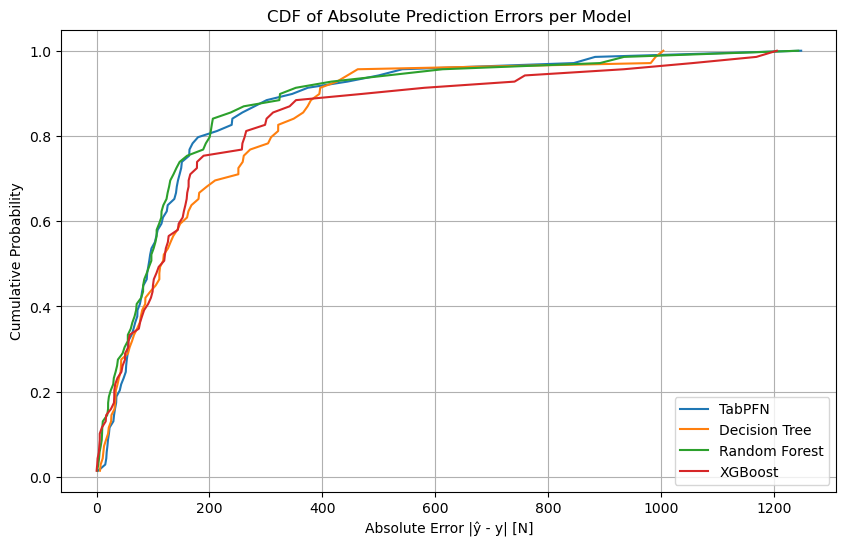

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for name, (errors, cdf) in cdf_data.items():
    plt.plot(errors, cdf, label=name)

plt.xlabel("Absolute Error |ŷ - y| [N]")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Absolute Prediction Errors per Model")
plt.grid(True)
plt.legend()
plt.show()